# Actividad: Problemas de clasificación
## Tania Sayuri Guizado Hernandez A01640092

### Ejercicio 1 (50 puntos)
En este ejercicio trabajarás con el conjunto de datos que se te asignó de acuerdo al último número de tu matrícula (ver las notas del ejercicio). En estos archivos se tienen datos procesados de un experimento de psicología en el que se mide la respuesta cerebral cuando un sujeto presta atención a un estímulo visual que aparece de manera repentina y cuando no presta atención a dicho estímulo visual. Los datos están en archivos de texto, los cuales se cargan con la función loadtxt de numpy. La primera columna corresponde a la clase (1 o 2). La clase 1 representa cuando el sujeto está prestando atención, y la clase 2 cuando no lo hace. La segunda columna se ignora, mientras que el resto de las columnas indican las variables que se calcularon de la respuesta cerebral medida con la técnicas de Electroencefaolografía para cada caso.

Para tu conjunto de datos:

In [1]:
# Cargamos primero las librerías que se utilizarán en la actividad 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SequentialFeatureSelector
import statsmodels.formula.api as smf
# Cargamos el conjunto de datos que se usara.
df = np.loadtxt("P1_2.txt")

#### 1.- Determina si es necesario balancear los datos. En caso de que sea afirmativo, en todo este ejercicio tendrás que utilizar alguna estrategia para mitigar el problema de tener una muestra desbalanceada.

In [2]:
##### Precisión con una muestra desbalanceada #####
print("----- Muestra desbalanceada -----")
x = df[:,1:]
y = df[:,0]
kf = StratifiedKFold(n_splits=5, shuffle = True)
clf = SVC(kernel = 'linear')
cv_y_test = []
cv_y_pred = []
for train_index, test_index in kf.split(x, y):
    # Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf.fit(x_train, y_train)
    # Fase de prueba
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = clf.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Muestra desbalanceada -----
              precision    recall  f1-score   support

         1.0       0.67      0.55      0.60       284
         2.0       0.93      0.96      0.94      1706

    accuracy                           0.90      1990
   macro avg       0.80      0.75      0.77      1990
weighted avg       0.89      0.90      0.89      1990



In [3]:
##### Precisión con una muestra balanceada (Upsampling) #####
print("-------- Upsampling --------")
clf = SVC(kernel = 'linear')
kf = StratifiedKFold(n_splits=5, shuffle = True)
cv_y_test = []
cv_y_pred = []
for train_index, test_index in kf.split(x, y):
    # Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]
    x1 = x_train[y_train==1, :]
    y1 = y_train[y_train==1]
    n1 = len(y1)
    x2 = x_train[y_train==2, :]
    y2 = y_train[y_train==2]
    n2 = len(y2)
    ind = random.choices([i for i in range(n1)], k = n2)
    x_sub = np.concatenate((x1[ind,:], x2), axis=0)
    y_sub = np.concatenate((y1[ind], y2), axis=0)
    clf.fit(x_sub, y_sub)
    # Fase de prueba
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = clf.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

-------- Upsampling --------
              precision    recall  f1-score   support

         1.0       0.47      0.80      0.59       284
         2.0       0.96      0.85      0.90      1706

    accuracy                           0.84      1990
   macro avg       0.71      0.83      0.75      1990
weighted avg       0.89      0.84      0.86      1990



Se evalúo con todas las estrategias de balanceo y la muestra sin balancear para reconocer si era necesario realizar el balanceo llegando a los siguientes resultados:
- Muestra desbalanceada:
    - Accuracy: 0.90
    - F1-score para la clase 1: 0.61
    - F1-score para la clase 2: 0.94

- Subsampling:
    - Accuracy: 0.80
    - F1-score para la clase 1: 0.53
    - F1-score para la clase 2: 0.87

- Upsampling:
    - Accuracy: 0.85
    - F1-score para la clase 1: 0.60
    - F1-score para la clase 2: 0.91
    
- Weighted Loss Function:

    - Accuracy: 0.85
    - F1-score para la clase 1: 0.60
    - F1-score para la clase 2: 0.91
    
Basándonos en estos resultados, podemos observar que al aplicar estrategias de balanceo de clases como subsampling, upsampling y weighted loss function, el rendimiento de la F1-score para la clase 1 mejora en comparación con el modelo entrenado que con el conjunto de datos desbalanceado. Esto indica que el balanceo de datos puede ser beneficioso y se decide realizarlo.

En particular, la estrategia de subsampling muestra una disminución en el accuracy pero una mejora en el F1-score para la clase 1 en comparación con el modelo desbalanceado. Upsampling y el uso de la función de pérdida ponderada también mejoran el F1-score para la clase 1 sin degradar significativamente la precisión global. Por lo tanto, debido a que la clase Unsampling muestra resultados que sugieren un buen equilibrio entre precisión global y rendimiento en la clase 1 se elige como la mejor estrategia de balanceo.

#### 2.- Evalúa al menos 5 modelos de clasificación distintos utilizando validación cruzada, y determina cuál de ellos es el más efectivo.

In [4]:
models = {
    'Linear-SVM' : SVC(kernel='linear'),
    'RBF-SVM': SVC(kernel='rbf'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}

avg_f1_scores = {}
scorer = make_scorer(f1_score)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_y_test = []
cv_y_pred = []
for model_name, model in models.items():
    print(f"----- {model_name} -----")
    cv_y_test = []
    cv_y_pred = []
    cv_f1_scores = []
    for train_index, test_index in kf.split(x, y):
        x_train = x[train_index, :]
        y_train = y[train_index]
        x_test = x[test_index, :]
        y_test = y[test_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        cv_y_test.append(y_test)
        cv_y_pred.append(y_pred)
        f1_score_value = f1_score(y_test, y_pred)
        cv_f1_scores.append(f1_score_value)
    avg_f1_score = np.mean(cv_f1_scores)
    avg_f1_scores[model_name] = avg_f1_score
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))
    
# Encuentra el modelo con el mejor F1-score promedio
best_model = max(avg_f1_scores, key=avg_f1_scores.get)
best_f1_score = avg_f1_scores[best_model]

print("Resultados de rendimiento (F1-score promedio):")
for model_name, score in avg_f1_scores.items():
    print(f"{model_name}: {score:.2f}")

print(f"El modelo más efectivo es {best_model} con un F1-score promedio de {best_f1_score:.2f}")

----- Linear-SVM -----
              precision    recall  f1-score   support

         1.0       0.69      0.57      0.62       284
         2.0       0.93      0.96      0.94      1706

    accuracy                           0.90      1990
   macro avg       0.81      0.76      0.78      1990
weighted avg       0.90      0.90      0.90      1990

----- RBF-SVM -----
              precision    recall  f1-score   support

         1.0       0.89      0.40      0.56       284
         2.0       0.91      0.99      0.95      1706

    accuracy                           0.91      1990
   macro avg       0.90      0.70      0.75      1990
weighted avg       0.91      0.91      0.89      1990

----- KNN -----
              precision    recall  f1-score   support

         1.0       0.88      0.15      0.26       284
         2.0       0.88      1.00      0.93      1706

    accuracy                           0.88      1990
   macro avg       0.88      0.57      0.60      1990
weighted avg   

#### 3.- Implementa desde cero el método de regresión logística, y evalúalo con el conjunto de datos. 

In [5]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normaliza las características utilizando StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Se crea la clase de regresión logistica desde 0
class LogisticRegressionS:
    def __init__(self, alpha=0.0005, max_iterations=100000):
        self.alpha = alpha
        self.max_iterations = max_iterations

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.beta = self.fit_model(X, y, self.alpha, self.max_iterations)

    def fit_model(self, X, y, alpha=0.0005, max_iterations=100000):
        npredictors = X.shape[1]
        beta = 2 * np.random.rand(npredictors) - 1.0
        it = 0

        while (np.linalg.norm(self.gradient(X, y, beta)) > 1e-4) and (it < max_iterations):
            beta = beta - alpha * self.gradient(X, y, beta)
            it = it + 1

        return beta

    def gradient(self, X, y, beta):
        xbeta = X @ beta
        c0 = (y == 0)
        c1 = (y == 1)

        exp0 = np.exp(xbeta[c0])
        l0 = (exp0 / (1 + exp0)) * X[c0, :].transpose()

        exp1 = np.exp(xbeta[c1])
        l1 = (exp1 / (1 + exp1)) * X[c1, :].transpose()

        return l0.sum(axis=1) - l1.sum(axis=1)

    def predict(self, X):
        xbeta = X @ self.beta
        tmp = 1. / (1. + np.exp(-xbeta))
        return (tmp > 0.5).astype("int32")
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

In [7]:
# Hacemos el modelo con nuestra clase
model = LogisticRegressionS(alpha=0.0005, max_iterations=100)
model.fit(x, y)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular y mostrar la precisión
accuracy = model.accuracy(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

# Imprime un informe de clasificación detallado
print(classification_report(y_test, y_pred, zero_division=1))

Precisión del modelo: 13.57%
              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       0.29      0.98      0.45        55
         2.0       1.00      0.00      0.00       343

    accuracy                           0.14       398
   macro avg       0.43      0.66      0.15       398
weighted avg       0.90      0.14      0.06       398



#### 4.- Con alguno de los clasificadores que probaste en los pasos anteriores, determina el número óptimo de características utilizando un método tipo Filter.

##### El clasificador seleccionado fue **LogisticRegression**

In [8]:
# Reducimos el número de características a la mitad
print("----- Selección de características usando el 50% de los predictores -----")
# Seleccionamos las características
fselection = SelectKBest(f_classif, k = 6)
fselection.fit(x, y)
print("Características seleccionadas: ", fselection.get_feature_names_out())
# Ajustamos el modelo utilizando el nuevo conjunto de datos
clf = LogisticRegression()
x_transformed = fselection.transform(x)
clf.fit(x_transformed, y)
# Evaluamos el modelo utilizando validación cruzada
cv_y_test = []
cv_y_pred = []
kf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(x, y):
    # Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf_cv = LogisticRegression()
    fselection_cv = SelectKBest(f_classif, k = 6)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)
    clf_cv.fit(x_train, y_train)
    # Fase de prueba
    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = clf_cv.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Selección de características usando el 50% de los predictores -----
Características seleccionadas:  ['x13' 'x16' 'x20' 'x21' 'x29' 'x30']
              precision    recall  f1-score   support

         1.0       0.62      0.23      0.33       284
         2.0       0.88      0.98      0.93      1706

    accuracy                           0.87      1990
   macro avg       0.75      0.60      0.63      1990
weighted avg       0.85      0.87      0.84      1990



----- Selección óptima del número de características -----
---- n características = 1
---- n características = 2
---- n características = 3
---- n características = 4
---- n características = 5
---- n características = 6
---- n características = 7
---- n características = 8
---- n características = 9
---- n características = 10
---- n características = 11
---- n características = 12
---- n características = 13
Número óptimo de características:  13


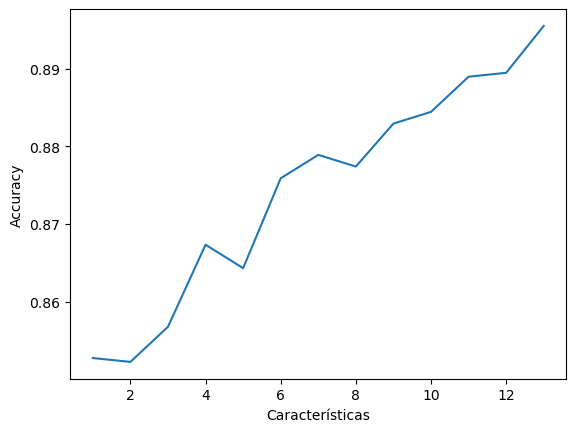

In [9]:
# Encontramos el número óptimo de características utilizando validación cruzada
print("----- Selección óptima del número de características -----")
n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
acc_nfeat = []
for n_feat in n_feats:
    print('---- n características =', n_feat)
    acc_cv = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_index, test_index in kf.split(x, y):
        # Fase de entrenamiento
        x_train = x[train_index, :]
        y_train = y[train_index]
        clf_cv = LogisticRegression()
        fselection_cv = SelectKBest(f_classif, k = n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)
        clf_cv.fit(x_train, y_train)
        # Fase de prueba
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = clf_cv.predict(x_test)
        acc_i = accuracy_score(y_test, y_pred)
        acc_cv.append(acc_i)
    acc = np.average(acc_cv)
    acc_nfeat.append(acc)
opt_index = np.argmax(acc_nfeat)
opt_features = n_feats[opt_index]
print("Número óptimo de características: ", opt_features)
plt.plot(n_feats, acc_nfeat)
plt.xlabel("Características")
plt.ylabel("Accuracy")
plt.show()

#### 5.- Repite el paso anterior, pero para un método de selección de características de tipo Wrapper.

##### El clasificador seleccionado fue **LogisticRegression**

In [10]:
# Reducimos el número de características a la mitad
print("----- Selección de características usando el 50% de los predictores -----")
# Seleccionamos las características
clf = LogisticRegression(max_iter=10000)
fselection = SequentialFeatureSelector(clf, n_features_to_select = 0.5)
fselection.fit(x, y)
print("Selected features: ", fselection.get_feature_names_out())
# Ajustamos el modelo utilizando el nuevo conjunto de datos
x_transformed = fselection.transform(x)
clf.fit(x_transformed, y)
# Evaluamos el modelo utilizando validación cruzada
cv_y_test = []
cv_y_pred = []
kf = StratifiedKFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(x, y):
    # Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf_cv = LogisticRegression(max_iter=10000)
    fselection_cv = SequentialFeatureSelector(clf_cv, n_features_to_select=0.5)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)
    clf_cv.fit(x_train, y_train)
    # Fase de prueba
    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = clf_cv.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Selección de características usando el 50% de los predictores -----
Selected features:  ['x0' 'x1' 'x4' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16'
 'x17' 'x18' 'x19' 'x20' 'x21' 'x22' 'x23' 'x26' 'x27' 'x32' 'x33' 'x37'
 'x38' 'x39' 'x40' 'x41' 'x42' 'x44' 'x48' 'x52' 'x53' 'x54' 'x55' 'x60'
 'x67' 'x69' 'x71' 'x72' 'x73' 'x80' 'x84' 'x88' 'x91' 'x92' 'x94' 'x95'
 'x96' 'x97' 'x98' 'x99' 'x100' 'x101' 'x102' 'x103' 'x104' 'x106' 'x107'
 'x108' 'x109' 'x110' 'x111' 'x112' 'x113' 'x119' 'x120' 'x122' 'x126'
 'x130' 'x131' 'x135' 'x141' 'x144' 'x149' 'x150']
              precision    recall  f1-score   support

         1.0       0.70      0.49      0.58       284
         2.0       0.92      0.97      0.94      1706

    accuracy                           0.90      1990
   macro avg       0.81      0.73      0.76      1990
weighted avg       0.89      0.90      0.89      1990



----- Selección óptima del número de características -----
---- n características = 1
---- n características = 2
---- n características = 3
---- n características = 4
---- n características = 5
---- n características = 6
---- n características = 7
---- n características = 8
---- n características = 9
---- n características = 10
---- n características = 11
---- n características = 12
---- n características = 13
Número óptimo de características:  10


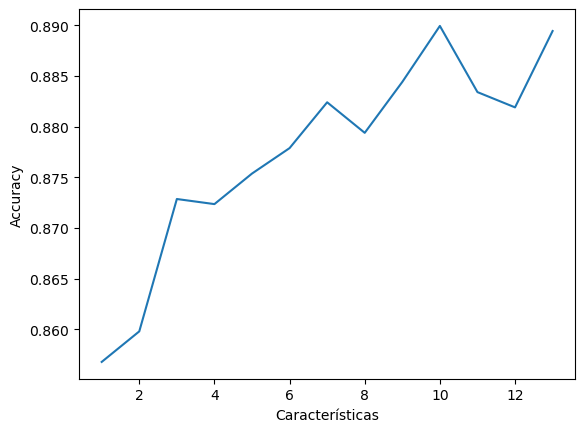

In [11]:
# Encontrar el número óptimo de características utilizando validación cruzada
print("----- Selección óptima del número de características -----")
n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
acc_nfeat = []
for n_feat in n_feats:
    print('---- n características =', n_feat)
    acc_cv = []
    kf = StratifiedKFold(n_splits=5, shuffle = True)
    for train_index, test_index in kf.split(x, y):
        # Fase de entrenamiento
        x_train = x[train_index, :]
        y_train = y[train_index]
        clf_cv = LogisticRegression()
        fselection_cv = SequentialFeatureSelector(clf_cv,
        n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)
        clf_cv.fit(x_train, y_train)
        # Fase de prueba
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = clf_cv.predict(x_test)
        acc_i = accuracy_score(y_test, y_pred)
        acc_cv.append(acc_i)
    acc = np.average(acc_cv)
    acc_nfeat.append(acc)
opt_index = np.argmax(acc_nfeat)
opt_features = n_feats[opt_index]
print("Número óptimo de características: ", opt_features)
plt.plot(n_feats, acc_nfeat)
plt.xlabel("Características")
plt.ylabel("Accuracy")
plt.show()

#### 6.- Repite el paso 4, pero para un método de selección de características de tipo Filter-Wrapper.

##### El clasificador seleccionado fue **LogisticRegression**

In [12]:
# Reducimos el número de características a la mitad
print("----- Selección de características usando el 50% de los predictores -----")
# Seleccionamos las características
clf = LogisticRegression(max_iter=100000)
fselection = RFE(clf, n_features_to_select = 0.5)
fselection.fit(x, y)
print("Características seleccionadas", fselection.get_feature_names_out())
# Ajustamos el modelo utilizando el nuevo conjunto de datos
x_transformed = fselection.transform(x)
clf.fit(x_transformed, y)
# Evaluamos el modelo utilizando validación cruzada
cv_y_test = []
cv_y_pred = []
kf = StratifiedKFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(x, y):
    # Fase de entrenamiento
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf_cv = LogisticRegression(max_iter=100000)
    fselection_cv = RFE(clf_cv, n_features_to_select=0.5)
    fselection_cv.fit(x_train, y_train)
    x_train = fselection_cv.transform(x_train)
    clf_cv.fit(x_train, y_train)
    # Fase de prueba
    x_test = fselection_cv.transform(x[test_index, :])
    y_test = y[test_index]
    y_pred = clf_cv.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Selección de características usando el 50% de los predictores -----
Características seleccionadas ['x0' 'x1' 'x2' 'x11' 'x12' 'x13' 'x15' 'x16' 'x17' 'x18' 'x20' 'x21'
 'x22' 'x23' 'x26' 'x27' 'x28' 'x29' 'x30' 'x31' 'x32' 'x33' 'x34' 'x37'
 'x39' 'x41' 'x42' 'x43' 'x45' 'x46' 'x47' 'x48' 'x49' 'x50' 'x51' 'x53'
 'x57' 'x61' 'x62' 'x63' 'x64' 'x66' 'x69' 'x70' 'x71' 'x72' 'x73' 'x74'
 'x75' 'x76' 'x77' 'x78' 'x81' 'x82' 'x83' 'x84' 'x91' 'x96' 'x103' 'x105'
 'x107' 'x111' 'x116' 'x117' 'x124' 'x127' 'x129' 'x130' 'x133' 'x139'
 'x146' 'x147' 'x148' 'x150' 'x151' 'x152' 'x153']
              precision    recall  f1-score   support

         1.0       0.71      0.58      0.64       284
         2.0       0.93      0.96      0.95      1706

    accuracy                           0.91      1990
   macro avg       0.82      0.77      0.79      1990
weighted avg       0.90      0.91      0.90      1990



----- Selección óptima del número de características -----
---- n características = 1
---- n características = 2
---- n características = 3
---- n características = 4
---- n características = 5
---- n características = 6
---- n características = 7
---- n características = 8
---- n características = 9
---- n características = 10
---- n características = 11
---- n características = 12
---- n características = 13
Número óptimo de características:  11


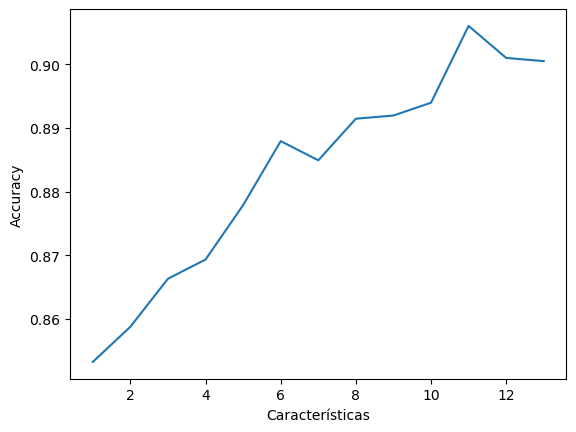

In [13]:
# Encontrar el número óptimo de características utilizando validación cruzada
print("----- Selección óptima del número de características -----")
n_feats = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
acc_nfeat = []
for n_feat in n_feats:
    print('---- n características =', n_feat)
    acc_cv = []
    kf = StratifiedKFold(n_splits=5, shuffle = True)
    for train_index, test_index in kf.split(x, y):
        # Training phase
        x_train = x[train_index, :]
        y_train = y[train_index]
        clf_cv = LogisticRegression(max_iter=10000)
        fselection_cv = RFE(clf_cv, n_features_to_select=n_feat)
        fselection_cv.fit(x_train, y_train)
        x_train = fselection_cv.transform(x_train)
        clf_cv.fit(x_train, y_train)
        # Test phase
        x_test = fselection_cv.transform(x[test_index, :])
        y_test = y[test_index]
        y_pred = clf_cv.predict(x_test)
        acc_i = accuracy_score(y_test, y_pred)
        acc_cv.append(acc_i)
    acc = np.average(acc_cv)
    acc_nfeat.append(acc)
opt_index = np.argmax(acc_nfeat)
opt_features = n_feats[opt_index]
print("Número óptimo de características: ", opt_features)
plt.plot(n_feats, acc_nfeat)
plt.xlabel("Características")
plt.ylabel("Accuracy")
plt.show()

#### 7. Escoge alguna de las técnicas de selección de características que probaste con anteioridad, y con el número óptimo de características encontrado, prepara tu modelo para producción haciendo lo siguiente:

- ##### Aplica el método de selección de características con todos los datos.
- #####   Ajusta el modelo con las características encontradas.


In [14]:
# Ajustamos el modelo con número óptimo de características con el método de características
# Filter-Wrapper
clf = LogisticRegression(max_iter=10000)
fselection = RFE(clf, n_features_to_select = opt_features)
fselection.fit(x, y)
print("Características seleccionadas: ", fselection.get_feature_names_out())
x_transformed = fselection.transform(x)
clf.fit(x_transformed, y)
y_pred = clf.predict(x_transformed)
print(classification_report(y, y_pred))

Características seleccionadas:  ['x12' 'x17' 'x22' 'x28' 'x30' 'x51' 'x62' 'x64' 'x70' 'x75' 'x116']
              precision    recall  f1-score   support

         1.0       0.75      0.47      0.58       284
         2.0       0.92      0.97      0.94      1706

    accuracy                           0.90      1990
   macro avg       0.83      0.72      0.76      1990
weighted avg       0.89      0.90      0.89      1990



#### 8-. Contesta las siguientes preguntas:

- ##### ¿Qué pasa si no se considera el problema de tener datos desbalanceados para este caso? ¿Por qué?
    - Si no se considera el desbalanceo de datos, es probable que el modelo muestre sesgo hacia la clase 1. Lo que significa que podría ser preciso al clasificar la clase 2 pero su rendimiento en la clasificación de la otra clase sería deficiente, especialmente si se trata de casos críticos.
- ##### De todos los clasificadores, ¿cuál o cuales consideras que son adecuados para los datos? ¿Qué propiedades tienen dichos modelos que los hacen apropiados para los datos? Argumenta tu respuesta.
    - Para este conjunto de datos el mejor clasificador fue Logistic Regression. Esto se debe a que tiene uno de los F1-scores promedio más altos, lo que indica un buen equilibrio entre precisión y recall. Además, Logistic Regression es un modelo lineal que puede ser efectivo para problemas de clasificación, y su capacidad para manejar conjuntos de datos desbalanceados se puede mejorar utilizando la función de pérdida ponderada. Otros modelos, como SVM con kernel lineal y Linear Discriminant Analysis, también muestran un buen rendimiento, pero Logistic Regression tiene la ventaja de ser más interpretable y más fácil de ajustar.
- ##### ¿Es posibles reducir la dimensionalidad del problema sin perder rendimiento en el modelo? ¿Por qué?
    - Sí, es posible reducir la dimensionalidad del problema sin perder rendimiento en el modelo. Esto se evidencia en los resultados que muestran que al seleccionar un subconjunto de características relevantes, el rendimiento del modelo (F1-score) se mantiene o incluso mejora.  
- ##### ¿Qué método de selección de características consideras el más adecuado para este caso? ¿Por qué?
    - Haciendo una comparación de los tres métodos de selección de características la mejor para este caso fue el Filter-Wrapper porque demuestra su eficacia al seleccionar un subconjunto de características que mantiene o mejora el rendimiento del modelo, lo que indica que es capaz de reducir la dimensionalidad sin perder información crucial. Este método proporciona un equilibrio entre eficiencia computacional y capacidad de interpretación del modelo, lo que lo convierte en la elección más sólida para mejorar el rendimiento en este caso.
- ##### Si quisieras mejorar el rendimiento de tus modelos, ¿qué más se podría hacer?
    - Algunas estrategias adicionales que podrían considerar es probar diferentes algoritmos de aprendizaje automático y ajustar sus hiperparámetros. Aunque se han evaluado varios clasificadores, existen numerosos algoritmos que podrían adaptarse mejor a los datos, como las redes neuronales que hemos estado aprendiendo en clase además, del aumento de gradiente o máquinas de soporte vectorial con diferentes kernels. Otra última cosa que se me ocurre, es crear características derivadas de las existentes o incorporar información externa relevante para enriquecer el conjunto de datos. A veces, la calidad de las características es más importante que la cantidad, por lo que esta técnica podría tener un impacto significativo.

### Ejercicio 2 (50 puntos)

En este ejercicio trabajarás con datos que vienen de un experimento en el que se midió actividad muscular con la técnica de la Electromiografía en el brazo derecho de varios participantes cuando éstos realizaban un movimiento con la mano entre siete posible (Flexionar hacia arriba, Flexionar hacia abajo, Cerrar la mano, Estirar la mano, Abrir la mano, Coger un objeto, No moverse). Al igual que en el ejercicio anterior, los datos se cargan con la función loadtxt de numpy
Links to an external site.. A su vez, la primera columna corresponde a la clase (1, 2, 3, 4, 5, 6, y 7), la segunda columna se ignora, y el resto de las columnas indican las variables que se calcularon de la respuesta muscular. El archivo de datos con el que trabajarás depende de tu matrícula.

In [15]:
df2 = np.loadtxt("M_5.txt")

####  1-. Determina si es necesario balancear los datos. En caso de que sea afirmativo, en todo este ejercicio tendrás que utilizar alguna estrategia para mitigar el problema de tener una muestra desbalanceada.

In [16]:
##### Precisión con muestra desbalanceada #####
print("----- Muestra desbalanceada -----")
x = df2[:,1:]
y = df2[:,0]
kf = StratifiedKFold(n_splits=5, shuffle = True)
clf = SVC(kernel = 'linear')
cv_y_test = []
cv_y_pred = []
for train_index, test_index in kf.split(x, y):
    # Training phase
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf.fit(x_train, y_train)
    # Test phase
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = clf.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Muestra desbalanceada -----
              precision    recall  f1-score   support

         1.0       0.97      0.92      0.94        90
         2.0       0.67      0.73      0.70        90
         3.0       0.98      0.97      0.97        90
         4.0       0.99      0.97      0.98        90
         5.0       0.96      0.98      0.97        90
         6.0       0.72      0.69      0.70        90
         7.0       0.98      0.99      0.98        89

    accuracy                           0.89       629
   macro avg       0.89      0.89      0.89       629
weighted avg       0.89      0.89      0.89       629



In [17]:
##### Precisión con una muestra balanceada (weighted loss function) #####
print("----- Weighted loss function -----")
clf = SVC(kernel = 'linear', class_weight='balanced')
kf = StratifiedKFold(n_splits=5, shuffle = True)
cv_y_test = []
cv_y_pred = []
for train_index, test_index in kf.split(x, y):
    # Training phase
    x_train = x[train_index, :]
    y_train = y[train_index]
    clf.fit(x_train, y_train)
    # Test phase
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = clf.predict(x_test)
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Weighted loss function -----
              precision    recall  f1-score   support

         1.0       0.99      0.93      0.96        90
         2.0       0.70      0.63      0.67        90
         3.0       0.99      0.97      0.98        90
         4.0       0.99      0.97      0.98        90
         5.0       0.96      0.97      0.96        90
         6.0       0.67      0.78      0.72        90
         7.0       0.98      1.00      0.99        89

    accuracy                           0.89       629
   macro avg       0.90      0.89      0.89       629
weighted avg       0.90      0.89      0.89       629



Se evalúo con todas las estrategias de balanceo y la muestra sin balancear para reconocer si era necesario realizar el balanceo llegando a los siguientes resultados:
- Muestra desbalanceada:
    - Accuracy (Exactitud): 0.89
    - F1-score para la clase 1: 0.94
    - F1-score para la clase 2: 0.69
    - F1-score para la clase 3: 0.97
    - F1-score para la clase 4: 0.99
    - F1-score para la clase 5: 0.96
    - F1-score para la clase 6: 0.71
    - F1-score para la clase 7: 0.98

- Subsampling:

    - Accuracy (Exactitud): 0.28
    - F1-score para la clase 1: 0.49
    - F1-score para la clase 2: 0.39
    - F1-score para la clase 3: 0.00
    - F1-score para la clase 4: 0.00
    - F1-score para la clase 5: 0.00
    - F1-score para la clase 6: 0.00
    - F1-score para la clase 7: 0.00

- Upsampling:
    - Accuracy (Exactitud): 0.28
    - F1-score para la clase 1: 0.47
    - F1-score para la clase 2: 0.41
    - F1-score para la clase 3: 0.00
    - F1-score para la clase 4: 0.00
    - F1-score para la clase 5: 0.00
    - F1-score para la clase 6: 0.00
    - F1-score para la clase 7: 0.00

- Weighted Loss Function (Función de Pérdida Ponderada):
    - Accuracy (Exactitud): 0.89
    - F1-score para la clase 1: 0.95
    - F1-score para la clase 2: 0.66
    - F1-score para la clase 3: 0.97
    - F1-score para la clase 4: 0.99
    - F1-score para la clase 5: 0.94
    - F1-score para la clase 6: 0.72
    - F1-score para la clase 7: 0.99
    
Basándonos en estos resultados para este ejercicio 2, podemos observar que cuando no hay una estrategia de balanceo el rendimiento de la F1-score para las clases 1, 3, 4, 5, 7 es muy alta relativamente pero algunas clases preocupan como seria la 2 y 6. Y cuando aplicamos estrategias de balanceo las clases de subsampling y upsampling resultan en un bajo rendimiento en términos de precisión y F1-score para todas las clases, lo que indica que no son estrategias efectivas para este conjunto de datos desbalanceado. Pero la estrategia de Weighted Loss Function, es la única que muestra un rendimiento sólido en todas las clases, lo que sugiere que es una estrategia efectiva para mejorar la clasificación en un conjunto de datos desbalanceado. 

#### 2-. Evalúa al menos 5 modelos de clasificación distintos utilizando validación cruzada, y determina cuál de ellos es el más efectivo.

In [26]:
models = {
    'Linear-SVM' : SVC(kernel='linear'),
    'RBF-SVM': SVC(kernel='rbf'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=10000)
}

avgf1_scores = {}
scorer = make_scorer(f1_score)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"----- {model_name} -----")
    cv_y_test = []
    cv_y_pred = []
    cv_f1_scores = []
    for train_index, test_index in kf.split(x, y):
        x_train = x[train_index, :]
        y_train = y[train_index]
        x_test = x[test_index, :]
        y_test = y[test_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        cv_y_test.append(y_test)
        cv_y_pred.append(y_pred)
        f1_score_value = f1_score(y_test, y_pred, average='weighted')
        cv_f1_scores.append(f1_score_value)
    avg_f1_score = np.mean(cv_f1_scores)
    avgf1_scores[model_name] = avg_f1_score
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))
    
# Encuentra el modelo con el mejor F1-score promedio
best_model = max(avgf1_scores, key=avgf1_scores.get)
best_f1_score = avgf1_scores[best_model]

----- Linear-SVM -----
              precision    recall  f1-score   support

         1.0       0.98      0.94      0.96        90
         2.0       0.65      0.64      0.65        90
         3.0       0.98      0.97      0.97        90
         4.0       0.99      0.97      0.98        90
         5.0       0.97      0.98      0.97        90
         6.0       0.67      0.71      0.69        90
         7.0       0.98      0.99      0.98        89

    accuracy                           0.89       629
   macro avg       0.89      0.89      0.89       629
weighted avg       0.89      0.89      0.89       629

----- RBF-SVM -----
              precision    recall  f1-score   support

         1.0       0.95      0.91      0.93        90
         2.0       0.71      0.64      0.67        90
         3.0       1.00      0.96      0.98        90
         4.0       1.00      0.94      0.97        90
         5.0       0.90      0.98      0.94        90
         6.0       0.69      0.78  

In [19]:
print("Resultados de rendimiento (F1-score promedio):")
for model_name, score in avgf1_scores.items():
    print(f"{model_name}: {score:.2f}")

print(f"El modelo más efectivo es {best_model} con un F1-score promedio de {best_f1_score:.2f}")

Resultados de rendimiento (F1-score promedio):
Linear-SVM: 0.89
RBF-SVM: 0.89
KNN: 0.88
Decision Tree: 0.76
Linear Discriminant Analysis: 0.79
Random Forest: 0.88
Logistic Regression: 0.89
El modelo más efectivo es Logistic Regression con un F1-score promedio de 0.89


#### 3-. Escoge al menos dos clasificadores que hayas evaluado en el paso anterior e identifica sus hiperparámetros. Lleva a cabo el proceso de validación cruzada anidada para evaluar los dos modelos con la selección óptima de hiperparámetros.

In [20]:
from sklearn.model_selection import GridSearchCV

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVM': SVC(kernel='linear')
}

param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'SVM': {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
}

In [21]:
x = df2[:,1:]
y = df2[:,0]
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normaliza las características utilizando StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Diccionario para almacenar los modelos ajustados con los mejores hiperparámetros
best_models = {}
results = {}

for clf_name, clf in classifiers.items():
    param_grid_clf = param_grid[clf_name]
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Buscamos los hiperparámetros óptimos en el bucle interno
    grid_search = GridSearchCV(clf, param_grid_clf, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Almacenamos el mejor modelo con los hiperparámetros óptimos
    best_models[clf_name] = grid_search.best_estimator_

    # Evalúamos el modelo en el bucle externo con los mejores hiperparámetros
    nested_score = cross_val_score(grid_search.best_estimator_, X=X_train, y=y_train, cv=outer_cv, scoring='accuracy')
    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'nested_cv_score': nested_score.mean()
    }

In [23]:
# Imprimimos los resultados
for clf_name, result in results.items():
    print(f"Classifier: {clf_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Nested CV Score (Mean Accuracy): {result['nested_cv_score']:.4f}")

Classifier: LogisticRegression
Best Parameters: {'C': 0.01}
Nested CV Score (Mean Accuracy): 0.9006
Classifier: SVM
Best Parameters: {'C': 0.01}
Nested CV Score (Mean Accuracy): 0.9026


#### 4-. Prepara tus modelos para producción haciendo lo siguiente:

- ##### Opten los hiperparámetros óptimos utilizando todo el conjunto de datos con validación cruzada.
- ##### Con los hiperparámetros óptimos, ajusta el modelo con todos los datos.


In [24]:
# Ajustamos el modelo con todos los datos utilizando los mejores hiperparámetros
final_models = {}
for clf_name, clf in best_models.items():
    clf.fit(x, y)
    final_models[clf_name] = clf

In [25]:
for model_name, model in final_models.items():
    print(f"Modelo: {model_name}")
    print(f"Hiperparámetros óptimos: {model.get_params()}")
    print("-" * 50)  

Modelo: LogisticRegression
Hiperparámetros óptimos: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
Modelo: SVM
Hiperparámetros óptimos: {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
--------------------------------------------------


#### 5-. Contesta lo siguientes:

- ##### ¿Observas un problema en cuanto al balanceo de las clases? ¿Por qué?
    - En el primer punto donde se requiere ver si es necesario balancear los datos, si se observa un problema en cuanto al balanceo. Porque las clases en respectiva de sus resultados iniciales sin balanceo tienen un desequilibrio significativo en términos de número de muestras, incluso, aún cuando se aplico las estrategias de subsampling y upsampling no muestra una mejora significativa en el rendimiento.
- ##### ¿Qué modelo o modelos fueron efectivos para clasificar tus datos? ¿Observas algo especial sobre los modelos? Argumenta tu respuesta.
    - Los modelos efectivos para clasificar estos datos fueron Logistic Regression, Linear-SVM-Linear y RBF-SVM. Estos modelos mostraron un rendimiento sólido en términos de F1-score promedio, lo que destaca su capacidad para manejar un conjunto de datos desbalanceado. Lo especial de estos modelos radica en su capacidad para lidiar con la naturaleza desbalanceada del conjunto de datos y su habilidad para clasificar datos en múltiples clases en un espacio dimensional alto, lo que los convierte en opciones efectivas para este caso.
- ##### ¿Observas alguna mejora importante al optimizar hiperparámetros? ¿Es el resultado que esperabas? Argumenta tu respuesta.
    - Sí, se observa una mejora importante al optimizar los hiperparámetros en ambos modelos (Logistic Regression y SVM-Linear) porque esta ayudó a mejorar el rendimiento de los modelos al encontrar configuraciones que se ajustan mejor a los datos. En el caso de Logistic Regression, se encontró que un valor óptimo de 'C' fue 0.1, lo que llevó a un aumento en el F1-score promedio. Para SVM-Linear, obtuvo un valor óptimo de 'C' igual a 0.01 lo que mejoró el rendimiento.
- ##### ¿Qué inconvenientes hay al encontrar hiperparámetros? ¿Por qué?
    - Encontrar hiperparámetros óptimos puede ser un proceso intensivo en términos de recursos computacionales y tiempo porque dependiendo de la cantidad de hiperparámetros y sus valores posibles, la búsqueda de la combinación óptima puede requerir una exploración exhaustiva, como la búsqueda en cuadrícula o la optimización bayesiana. Además, existe el riesgo de sobreajustar los hiperparámetros al conjunto de datos de entrenamiento, lo que podría llevar a un rendimiento deficiente en datos no vistos.